In [1]:
import os
import cv2
import numpy as np
import keras
import glob

import matplotlib.pyplot as plt
%matplotlib inline

from convlstm_autoencoder import ConvLSTMAutoEncoder
from datagen import BatchGenerator

from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from PIL import Image

Using TensorFlow backend.


In [3]:
# model = ConvLSTMAutoEncoder(input_shape=(50, 48, 48, 3))

In [4]:
# Load pre-trained model

model = keras.models.load_model("./log/base/bestweights.hdf5")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "ConvLSTMAutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 50, 48, 48, 64)    154624    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 48, 48, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 24, 24, 64)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 50, 24, 24, 64)    295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 24, 24, 64)    256       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 50, 12, 12, 64)    0   

### Build Video Encoder: (50, 48, 48, 3) -> (50, 12, 12, 3)

In [5]:
layer_name = 'conv3d_1'

encoder = keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1_input (InputL (None, 50, 48, 48, 3)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 50, 48, 48, 64)    154624    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 48, 48, 64)    256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 24, 24, 64)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 50, 24, 24, 64)    295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 24, 24, 64)    256       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 50, 12, 12, 64)    0   

In [6]:
pprint( os.listdir("data/video/20bn-jester-v1/1/") )

['00037.jpg',
 '00009.jpg',
 '00008.jpg',
 '00032.jpg',
 '00011.jpg',
 '00016.jpg',
 '00021.jpg',
 '00003.jpg',
 '00031.jpg',
 '00028.jpg',
 '00030.jpg',
 '00013.jpg',
 '00010.jpg',
 '00004.jpg',
 '00017.jpg',
 '00025.jpg',
 '00035.jpg',
 '00005.jpg',
 '00036.jpg',
 '00006.jpg',
 '00023.jpg',
 '00012.jpg',
 '00015.jpg',
 '00001.jpg',
 '00014.jpg',
 '00024.jpg',
 '00007.jpg',
 '00020.jpg',
 '00019.jpg',
 '00029.jpg',
 '00018.jpg',
 '00034.jpg',
 '00022.jpg',
 '00027.jpg',
 '00026.jpg',
 '00033.jpg',
 '00002.jpg']


### Feed Sample video 

In [7]:
frame_id=1

bgen = BatchGenerator(video_path="./data/video/20bn-jester-v1",
                                            img_size=(48, 48), 
                                            batch_size=1, 
                                            use_padding=True)
                                            
video, label = bgen.__getitem__(frame_id)

In [8]:
video.shape

(1, 50, 48, 48, 3)

In [9]:
hidden_output = encoder.predict(video)

In [10]:
hidden_output.shape

(1, 50, 12, 12, 3)

In [11]:
hidden_output[0][0].shape

(12, 12, 3)

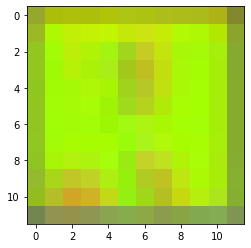

In [46]:
for i in range(50):
    img = hidden_output[0][i] * 255.
    img = (img - img.min()) / (img.max() - img.min())
    
    # plt.figure()
    plt.imshow(img)
    plt.savefig("id1_latent_img_"+str(i)+".jpg")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


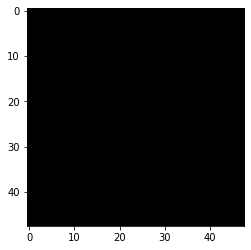

In [47]:
for i in range(50):
    img = video[0][i] * 255.
    img = (img - img.min()) / (img.max() - img.min())
    # plt.figure()
    plt.imshow(img)
    plt.savefig("id1_ori_img_"+str(i)+".jpg")

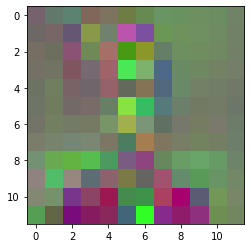

In [13]:
img = hidden_output[0][10] * 255.
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

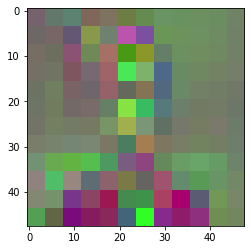

In [15]:
img_r = img.repeat(4, axis=0).repeat(4, axis=1)
plt.imshow(img_r)

In [ ]:
image.repeat(2, axis=0).repeat(2, axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


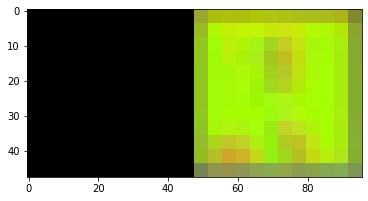

In [19]:
for i in range(50):
    ori_img = video[0][i] * 255.
    ori_img = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min())
    
    lat_img = hidden_output[0][i] * 255.
    lat_img = (lat_img - lat_img.min()) / (lat_img.max() - lat_img.min())
    lat_img = lat_img.repeat(4, axis=0).repeat(4, axis=1)
    
    concat_img = cv2.hconcat([ori_img, lat_img])

    # plt.figure()
    plt.imshow(concat_img)
    plt.savefig("id1_concat_img_"+str(i)+".jpg")

In [22]:
def make_gif(img_path='./demo/concat/*.jpg', gif_name='concat.gif'):
    files = sorted(glob.glob(img_path))
    images = list(map(lambda file: Image.open(file), files))
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=400, loop=0)

In [23]:
make_gif(img_path='./demo/original/*.jpg', gif_name='original.gif')
make_gif(img_path='./demo/latent/*.jpg', gif_name='latent.gif')
make_gif(img_path='./demo/concat/*.jpg', gif_name='concat.gif')

In [17]:
frame_id=100

bgen = BatchGenerator(video_path="./data/latent1118/",
                                            img_size=(48, 48), 
                                            batch_size=1, 
                                            use_padding=True)
                                            
video, label = bgen.__getitem__(frame_id)

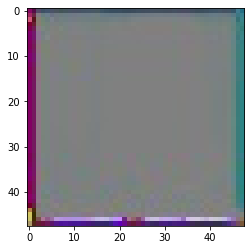

In [24]:
plt.imshow(video[0][0])

lat.jpg
